In [15]:
import torch
import dgl
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# Generate random 2D coordinate data
num_points = 500
coords = np.random.rand(num_points, 2) * 2 - 1  # Coordinates in the range [-1, 1]

# Create a graph using DGL
g = dgl.DGLGraph()
g.add_nodes(num_points)
g.ndata['coord'] = torch.tensor(coords, dtype=torch.float32)

# Defining the quadrants
quadrant_labels = torch.zeros(num_points, dtype=torch.long)
quadrant_labels[(coords[:, 0] > 0) & (coords[:, 1] > 0)] = 0  # Quadrant 1
quadrant_labels[(coords[:, 0] < 0) & (coords[:, 1] > 0)] = 1  # Quadrant 2
quadrant_labels[(coords[:, 0] < 0) & (coords[:, 1] < 0)] = 2  # Quadrant 3
quadrant_labels[(coords[:, 0] > 0) & (coords[:, 1] < 0)] = 3  # Quadrant 4

# Add self-loops to the graph
g.add_edges(g.nodes(), g.nodes())

In [30]:
# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GNN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(in_feats, hidden_size)
        self.conv2 = dgl.nn.GraphConv(hidden_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, num_classes)
        
    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = torch.relu(self.conv2(g, x))
        g.ndata['h'] = x
        g.update_all(message_func=dgl.function.copy_u('h', 'm'), reduce_func=dgl.function.sum('m', 'x'))
        x = torch.relu(self.fc(g.ndata['x']))
        return torch.softmax(x, dim=1)

# Define the training loop
def train(model, g, features, labels, train_mask, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = model(g, features)
        train_logits = logits[train_mask]
        train_labels = labels[train_mask]
        loss = criterion(train_logits, train_labels)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    
    return model

# Split the data into training and test sets
train_mask = torch.randperm(num_points)[:int(0.8 * num_points)]
test_mask = torch.ones(num_points, dtype=torch.bool)
test_mask[train_mask] = False

In [31]:
# Create the GNN model
model = GNN(in_feats=2, hidden_size=16, num_classes=4)  # 2 inputfeatures (x, y), 4 classes for the quadrants

# Train the model
model = train(model, g, g.ndata['coord'], quadrant_labels, train_mask, epochs=50)

# Evaluate the model
with torch.no_grad():
    logits = model(g, g.ndata['coord'])
    predicted_labels = torch.argmax(logits, dim=1)

Epoch 10/50, Loss: 1.3448148965835571
Epoch 20/50, Loss: 1.2453553676605225
Epoch 30/50, Loss: 1.0545547008514404
Epoch 40/50, Loss: 0.8815223574638367
Epoch 50/50, Loss: 0.8183425664901733


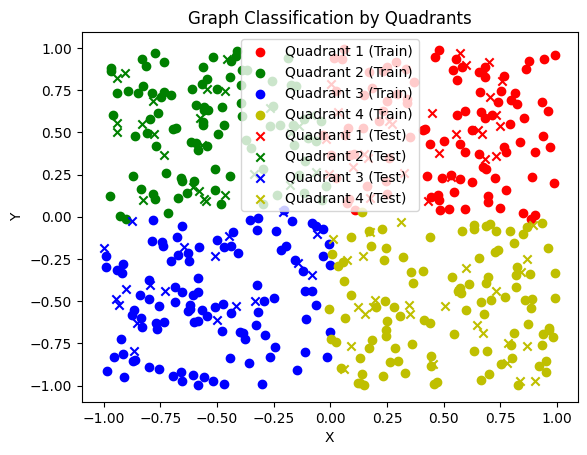

In [32]:
# Plot the graphs and their predicted quadrant labels
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['r', 'g', 'b', 'y']  # Colors for each quadrant

# Plot the training points with their predicted quadrant labels
train_coords = coords[train_mask]
train_labels = predicted_labels[train_mask]
for i in range(4):
    mask = train_labels == i
    ax.scatter(train_coords[mask, 0], train_coords[mask, 1], color=colors[i], label=f'Quadrant {i+1} (Train)')
# Plot the test points with their predicted quadrant labels
test_coords = coords[test_mask]
test_labels = predicted_labels[test_mask]
for i in range(4):
    mask = test_labels == i
    ax.scatter(test_coords[mask, 0], test_coords[mask, 1], color=colors[i], marker='x', label=f'Quadrant {i+1} (Test)')

ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Graph Classification by Quadrants')
plt.show()